📂 Please upload your Excel file...


Saving HousePricePrediction.xlsx to HousePricePrediction.xlsx
✅ File uploaded: HousePricePrediction.xlsx
✅ Dataset Loaded | Shape: (2919, 13)
📌 Columns: ['Id', 'MSSubClass', 'MSZoning', 'LotArea', 'LotConfig', 'BldgType', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'Exterior1st', 'BsmtFinSF2', 'TotalBsmtSF', 'SalePrice']

📊 Linear Regression Performance:
RMSE: 54022.74
R² Score: 0.6195


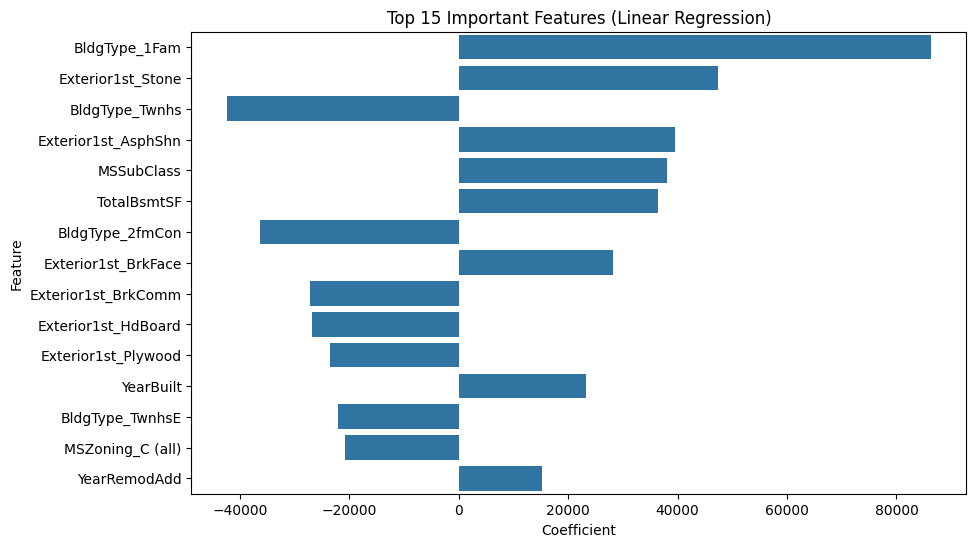


📈 Polynomial Regression Performance:
RMSE: 63642.82
R² Score: 0.4719


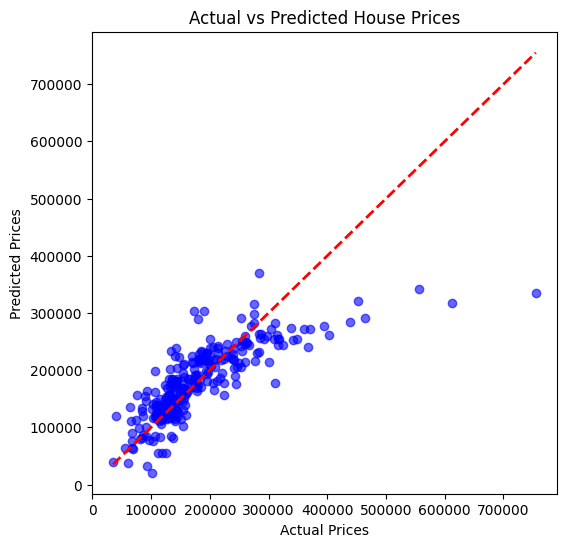

In [2]:
# ============================
# House Price Prediction - Google Colab Version
# ============================

# 1. Install and Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

# -----------------------------
# 2. Upload and Load Dataset
# -----------------------------
print("📂 Please upload your Excel file...")
uploaded = files.upload()

file_name = list(uploaded.keys())[0]
print(f"✅ File uploaded: {file_name}")

data = pd.read_excel(file_name)
print(f"✅ Dataset Loaded | Shape: {data.shape}")
print("📌 Columns:", data.columns.tolist())

# -----------------------------
# 3. Preprocessing
# -----------------------------
data = data.drop(columns=["Id"], errors="ignore")

train_data = data[data["SalePrice"].notnull()].copy()
test_data = data[data["SalePrice"].isnull()].drop(columns=["SalePrice"], errors="ignore").copy()

X = train_data.drop(columns=["SalePrice"])
y = train_data["SalePrice"]

categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
numerical_cols = X.select_dtypes(exclude=["object"]).columns.tolist()

# -----------------------------
# 4. Preprocessing Pipeline
# -----------------------------
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])

# -----------------------------
# 5. Train-Test Split
# -----------------------------
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# -----------------------------
# 6. Build & Train Model
# -----------------------------
model = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', LinearRegression())])
model.fit(X_train, y_train)

# -----------------------------
# 7. Predictions & Evaluation
# -----------------------------
y_pred = model.predict(X_valid)
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
r2 = r2_score(y_valid, y_pred)

print("\n📊 Linear Regression Performance:")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

# -----------------------------
# 8. Feature Importance
# -----------------------------
encoded_features = model.named_steps['preprocessor'].transformers_[1][1].named_steps['encoder'].get_feature_names_out(categorical_cols)
all_features = numerical_cols + encoded_features.tolist()
coefficients = model.named_steps['regressor'].coef_

coef_df = pd.DataFrame({"Feature": all_features, "Coefficient": coefficients}).sort_values(by="Coefficient", key=abs, ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x="Coefficient", y="Feature", data=coef_df.head(15))
plt.title("Top 15 Important Features (Linear Regression)")
plt.show()

# -----------------------------
# 9. Polynomial Regression
# -----------------------------
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(preprocessor.fit_transform(X))
X_train_p, X_valid_p, y_train_p, y_valid_p = train_test_split(X_poly, y, test_size=0.2, random_state=42)

poly_model = LinearRegression()
poly_model.fit(X_train_p, y_train_p)
y_pred_p = poly_model.predict(X_valid_p)

rmse_poly = np.sqrt(mean_squared_error(y_valid_p, y_pred_p))
r2_poly = r2_score(y_valid_p, y_pred_p)

print("\n📈 Polynomial Regression Performance:")
print(f"RMSE: {rmse_poly:.2f}")
print(f"R² Score: {r2_poly:.4f}")

# -----------------------------
# 10. Actual vs Predicted Visualization
# -----------------------------
plt.figure(figsize=(6, 6))
plt.scatter(y_valid, y_pred, alpha=0.6, color="blue")
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], color="red", linestyle="--", linewidth=2)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted House Prices")
plt.show()
